In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.nasnet import NASNetLarge
from tensorflow.keras.applications.nasnet import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob

In [2]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from skimage import color
from skimage import io
from skimage.transform import rescale, resize
from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
from keras.models import Sequential
import tensorflow as tf
import warnings

In [3]:
import os
f=[] 
def listdirs(rootdir):
    for file in os.listdir(rootdir):
        d = os.path.join(rootdir, file)
        if os.path.isdir(d):
            print(d)
            f.append(d)
            listdirs(d)
 
rootdir = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
listdirs(rootdir)

../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca
../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc
../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n


In [4]:
import pandas as pd
from pathlib import Path

image_dir_path = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n'
paths = [path.parts[-3:] for path in
         Path(image_dir_path).rglob('*.jpeg')]
df1 = pd.DataFrame(data=paths, columns=['Root', 'Type', 'Images'])
print(df1)


image_dir_path = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc'
paths = [path.parts[-3:] for path in
         Path(image_dir_path).rglob('*.jpeg')]
df2 = pd.DataFrame(data=paths, columns=['Root', 'Type', 'Images'])
print(df2)
image_dir_path ='../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca'
paths = [path.parts[-3:] for path in
         Path(image_dir_path).rglob('*.jpeg')]
df3 = pd.DataFrame(data=paths, columns=['Root', 'Type', 'Images'])
print(df3)

                 Root    Type          Images
0     lung_image_sets  lung_n   lungn691.jpeg
1     lung_image_sets  lung_n  lungn3098.jpeg
2     lung_image_sets  lung_n  lungn4225.jpeg
3     lung_image_sets  lung_n    lungn40.jpeg
4     lung_image_sets  lung_n  lungn4213.jpeg
...               ...     ...             ...
4995  lung_image_sets  lung_n  lungn1469.jpeg
4996  lung_image_sets  lung_n  lungn1508.jpeg
4997  lung_image_sets  lung_n  lungn1966.jpeg
4998  lung_image_sets  lung_n  lungn4090.jpeg
4999  lung_image_sets  lung_n   lungn554.jpeg

[5000 rows x 3 columns]
                 Root      Type            Images
0     lung_image_sets  lung_scc  lungscc1930.jpeg
1     lung_image_sets  lung_scc  lungscc1441.jpeg
2     lung_image_sets  lung_scc  lungscc4624.jpeg
3     lung_image_sets  lung_scc  lungscc4038.jpeg
4     lung_image_sets  lung_scc  lungscc2504.jpeg
...               ...       ...               ...
4995  lung_image_sets  lung_scc  lungscc3958.jpeg
4996  lung_image_sets  

In [5]:
df = pd.concat([df1,df2,df3])
df.reset_index()

,index,Root,Type,Images
0,0,lung_image_sets,lung_n,lungn691.jpeg
1,1,lung_image_sets,lung_n,lungn3098.jpeg
2,2,lung_image_sets,lung_n,lungn4225.jpeg
3,3,lung_image_sets,lung_n,lungn40.jpeg
4,4,lung_image_sets,lung_n,lungn4213.jpeg
...,...,...,...,...
14995,4995,lung_image_sets,lung_aca,lungaca3823.jpeg
14996,4996,lung_image_sets,lung_aca,lungaca2457.jpeg
14997,4997,lung_image_sets,lung_aca,lungaca4147.jpeg
14998,4998,lung_image_sets,lung_aca,lungaca1477.jpeg


In [6]:
import os
os.makedirs('/kaggle/working/cmyk/lung_n')
os.makedirs('/kaggle/working/cmyk/lung_scc')
os.makedirs('/kaggle/working/cmyk/lung_aca')
os.makedirs('/kaggle/working/ycbcr/lung_n')
os.makedirs('/kaggle/working/ycbcr/lung_scc')
os.makedirs('/kaggle/working/ycbcr/lung_aca')

In [7]:
y = df.filter(['Type'])

In [8]:
y

,Type
0,lung_n
1,lung_n
2,lung_n
3,lung_n
4,lung_n
...,...
4995,lung_aca
4996,lung_aca
4997,lung_aca
4998,lung_aca


In [9]:
y['Type'].values[0]

'lung_n'

In [10]:
from zipfile import ZipFile
from PIL import Image
import os
def prepareImages(data, m, dataset):
    img_size=331
    print("Preparing images")
    X_train = np.zeros((m, img_size, img_size, 1))
    count = 0
    p=0
    for index,row in df.iterrows():
        img = image.load_img(r"../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/"+row["Type"]+"/"+row["Images"])
        img_rgb = Image.open(r"../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/"+row["Type"]+"/"+row["Images"])
        img_cmyk = img_rgb.convert('CMYK')
        img_ycbcr = img_rgb.convert('YCbCr')
        img_cmyk.save(r"./cmyk/"+y['Type'].values[count]+"/"+"processed"+str(count)+".jpeg")
        img_ycbcr.save(r"./ycbcr/"+y['Type'].values[count]+"/"+"processed"+str(count)+".jpeg")
        count += 1

In [11]:
df.shape[0]

15000

In [12]:
prepareImages(df, df.shape[0], "train")

Preparing images


In [13]:
IMAGE_SIZE = (331, 331, 3)

train_path_rgb = '../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
train_path_cmyk = '../working/cmyk/'
train_path_ycbcr = '..working/ycbcr/'

In [14]:
folders = glob('../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/*')
print(len(folders))

3


In [15]:
nasnetL1 = NASNetLarge(input_shape=IMAGE_SIZE, include_top=False, weights="imagenet")
nasnetL2 = NASNetLarge(input_shape=IMAGE_SIZE, include_top=False, weights="imagenet")
nasnetL3 = NASNetLarge(input_shape=IMAGE_SIZE, include_top=False, weights="imagenet")

2022-11-14 05:03:19.120991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 05:03:19.122041: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 05:03:19.315290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 05:03:19.316177: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-14 05:03:19.316986: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

343621632/343610240 [==============================] - 4s 0us/step


In [16]:
for layer in nasnetL1.layers:
    layer.trainable = False
for layer in nasnetL2.layers:
    layer.trainable = False
for layer in nasnetL3.layers:
    layer.trainable = False

In [17]:
x1 = Flatten()(nasnetL1.output)
x2 = Flatten()(nasnetL2.output)
x3 = Flatten()(nasnetL3.output)

In [18]:
prediction1 = Dense(len(folders), activation='softmax')(x1)
prediction2 = Dense(len(folders), activation='softmax')(x2)
prediction3 = Dense(len(folders), activation='softmax')(x3)
model1 = Model(inputs=nasnetL1.input, outputs=prediction1)
model2 = Model(inputs=nasnetL2.input, outputs=prediction2)
model3 = Model(inputs=nasnetL3.input, outputs=prediction3)

In [19]:
model1.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation (Activation)         (None, 165, 165, 96) 0           stem_bn1[0][0]                   
______________________________________________________________________________________________

In [20]:
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_2[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_260 (Activation)     (None, 165, 165, 96) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [21]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 331, 331, 3) 0                                            
__________________________________________________________________________________________________
stem_conv1 (Conv2D)             (None, 165, 165, 96) 2592        input_3[0][0]                    
__________________________________________________________________________________________________
stem_bn1 (BatchNormalization)   (None, 165, 165, 96) 384         stem_conv1[0][0]                 
__________________________________________________________________________________________________
activation_520 (Activation)     (None, 165, 165, 96) 0           stem_bn1[0][0]                   
____________________________________________________________________________________________

In [22]:
model1.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model2.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)
model3.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

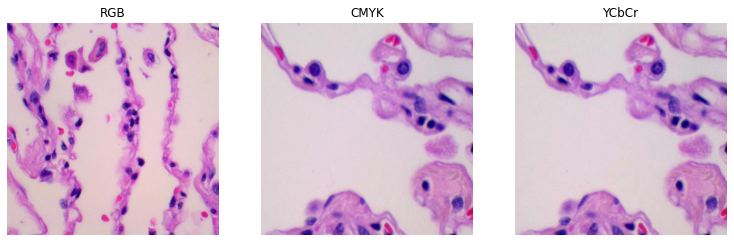

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img1 = mpimg.imread('../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n/lungn1.jpeg')
img2 = mpimg.imread('../working/cmyk/lung_n/processed1.jpeg')
img3 = mpimg.imread('../working/ycbcr/lung_n/processed1.jpeg')
plt.figure(figsize=(22,8))
plt.subplot(1, 5, 1)
plt.title('RGB')
plt.imshow(img1)
plt.axis('off')
plt.subplot(1, 5, 2)
plt.title('CMYK')
plt.imshow(img2)
plt.axis('off')
plt.subplot(1, 5, 3)
plt.title('YCbCr')
plt.imshow(img3)
plt.axis('off')
plt.show()

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
data1 = ImageDataGenerator(validation_split = 0.2,
                          rescale = 1./224,
                          shear_range = 0.2,
                          zoom_range = 0.2,
                          horizontal_flip = True)
data2 = ImageDataGenerator(validation_split = 0.2,
                          rescale = 1./224,
                          shear_range = 0.2,
                          zoom_range = 0.2,
                          horizontal_flip = True)
data3 = ImageDataGenerator(validation_split = 0.2,
                          rescale = 1./224,
                          shear_range = 0.2,
                          zoom_range = 0.2,
                          horizontal_flip = True)

In [25]:
training_set1 = data1.flow_from_directory(directory=r'../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/',
                                                 target_size = (331, 331),
                                                 batch_size = 64,
                                                 subset = "training",
                                                 class_mode = 'categorical')
training_set2 = data2.flow_from_directory(directory=r'../working/cmyk/',
                                                 target_size = (331, 331),
                                                 batch_size = 64,
                                                 subset = "training",
                                                 class_mode = 'categorical')
training_set3 = data3.flow_from_directory(directory=r'../working/ycbcr/',
                                                 target_size = (331, 331),
                                                 batch_size = 64,
                                                 subset = "training",
                                                 class_mode = 'categorical')

Found 12000 images belonging to 3 classes.
Found 12000 images belonging to 3 classes.
Found 12000 images belonging to 3 classes.


In [26]:
test_set1 = data1.flow_from_directory('../input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/',
                                            target_size = (331, 331),
                                            batch_size = 64,
                                            subset = "validation",
                                            class_mode = 'categorical')
test_set2 = data2.flow_from_directory('../working/cmyk/',
                                            target_size = (331, 331),
                                            batch_size = 64,
                                            subset = "validation",
                                            class_mode = 'categorical')
test_set3 = data3.flow_from_directory('../working/ycbcr/',
                                            target_size = (331, 331),
                                            batch_size = 64,
                                            subset = "validation",
                                            class_mode = 'categorical')

Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [27]:
r1 = model1.fit(
  training_set1,
  validation_data=test_set1,
  epochs=15,
  steps_per_epoch=len(training_set1),
  validation_steps=len(test_set1)
)

2022-11-14 05:03:56.729381: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84142848 exceeds 10% of free system memory.
2022-11-14 05:03:56.948381: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15


2022-11-14 05:04:13.848913: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84142848 exceeds 10% of free system memory.
2022-11-14 05:04:15.609908: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2022-11-14 05:04:16.358304: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84142848 exceeds 10% of free system memory.


  2/188 [..............................] - ETA: 4:53 - loss: 3.6667 - accuracy: 0.5078   

2022-11-14 05:04:29.331825: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84142848 exceeds 10% of free system memory.


  3/188 [..............................] - ETA: 6:26 - loss: 5.5430 - accuracy: 0.5260

2022-11-14 05:04:31.938522: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 84142848 exceeds 10% of free system memory.


188/188 [==============================] - 686s 4s/step - loss: 2.0858 - accuracy: 0.9093 - val_loss: 2.1417 - val_accuracy: 0.9207
Epoch 2/15
188/188 [==============================] - 646s 3s/step - loss: 1.2833 - accuracy: 0.9474 - val_loss: 1.6838 - val_accuracy: 0.9430
Epoch 3/15
188/188 [==============================] - 644s 3s/step - loss: 1.0728 - accuracy: 0.9592 - val_loss: 1.1092 - val_accuracy: 0.9587
Epoch 4/15
188/188 [==============================] - 645s 3s/step - loss: 0.9320 - accuracy: 0.9648 - val_loss: 0.9020 - val_accuracy: 0.9703
Epoch 5/15
188/188 [==============================] - 645s 3s/step - loss: 0.8495 - accuracy: 0.9711 - val_loss: 1.2004 - val_accuracy: 0.9670
Epoch 6/15
188/188 [==============================] - 644s 3s/step - loss: 0.9427 - accuracy: 0.9702 - val_loss: 1.1945 - val_accuracy: 0.9693
Epoch 7/15
188/188 [==============================] - 643s 3s/step - loss: 0.8120 - accuracy: 0.9743 - val_loss: 1.1476 - val_accuracy: 0.9690
Epoch 8/15

In [28]:
r2 = model2.fit(
  training_set2,
  validation_data=test_set2,
  epochs=15,
  steps_per_epoch=len(training_set2),
  validation_steps=len(test_set2)
)

Epoch 1/15
188/188 [==============================] - 741s 4s/step - loss: 2.0492 - accuracy: 0.9095 - val_loss: 1.5094 - val_accuracy: 0.9413
Epoch 2/15
188/188 [==============================] - 704s 4s/step - loss: 1.2208 - accuracy: 0.9511 - val_loss: 1.9976 - val_accuracy: 0.9260
Epoch 3/15
188/188 [==============================] - 699s 4s/step - loss: 1.1888 - accuracy: 0.9572 - val_loss: 0.9127 - val_accuracy: 0.9620
Epoch 4/15
188/188 [==============================] - 695s 4s/step - loss: 1.1252 - accuracy: 0.9630 - val_loss: 0.9882 - val_accuracy: 0.9643
Epoch 5/15
188/188 [==============================] - 696s 4s/step - loss: 0.8406 - accuracy: 0.9716 - val_loss: 0.8242 - val_accuracy: 0.9750
Epoch 6/15
188/188 [==============================] - 696s 4s/step - loss: 1.0314 - accuracy: 0.9693 - val_loss: 1.1605 - val_accuracy: 0.9683
Epoch 7/15
188/188 [==============================] - 696s 4s/step - loss: 0.9007 - accuracy: 0.9718 - val_loss: 1.3669 - val_accuracy: 0.9647

In [29]:
r3 = model3.fit(
  training_set3,
  validation_data=test_set3,
  epochs=15,
  steps_per_epoch=len(training_set3),
  validation_steps=len(test_set3)
)

Epoch 1/15
188/188 [==============================] - 662s 3s/step - loss: 2.7158 - accuracy: 0.9015 - val_loss: 1.1765 - val_accuracy: 0.9380
Epoch 2/15
188/188 [==============================] - 633s 3s/step - loss: 0.9921 - accuracy: 0.9507 - val_loss: 1.2988 - val_accuracy: 0.9497
Epoch 3/15
188/188 [==============================] - 634s 3s/step - loss: 1.1060 - accuracy: 0.9569 - val_loss: 1.5796 - val_accuracy: 0.9490
Epoch 4/15
188/188 [==============================] - 631s 3s/step - loss: 0.8929 - accuracy: 0.9652 - val_loss: 1.2638 - val_accuracy: 0.9597
Epoch 5/15
188/188 [==============================] - 635s 3s/step - loss: 0.9293 - accuracy: 0.9682 - val_loss: 0.7696 - val_accuracy: 0.9673
Epoch 6/15
188/188 [==============================] - 633s 3s/step - loss: 0.7828 - accuracy: 0.9732 - val_loss: 0.8454 - val_accuracy: 0.9723
Epoch 7/15
188/188 [==============================] - 633s 3s/step - loss: 0.7551 - accuracy: 0.9758 - val_loss: 1.2796 - val_accuracy: 0.9667

In [30]:
import matplotlib.pyplot as plt

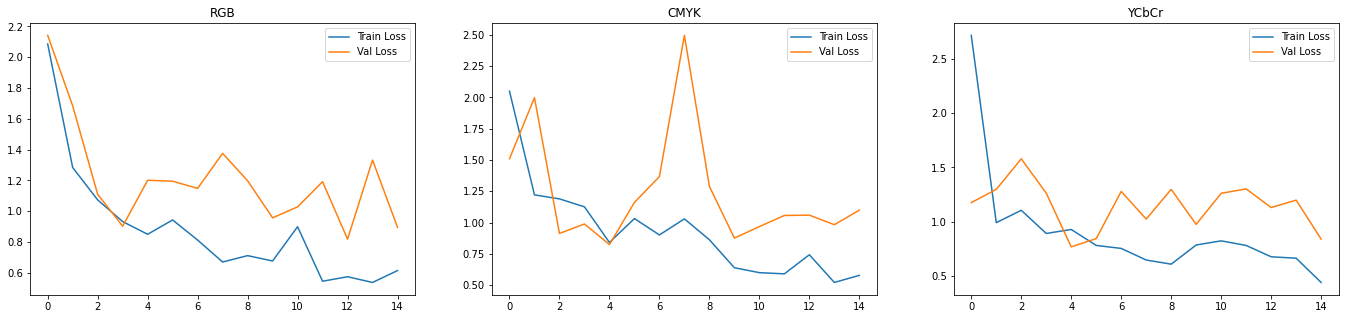

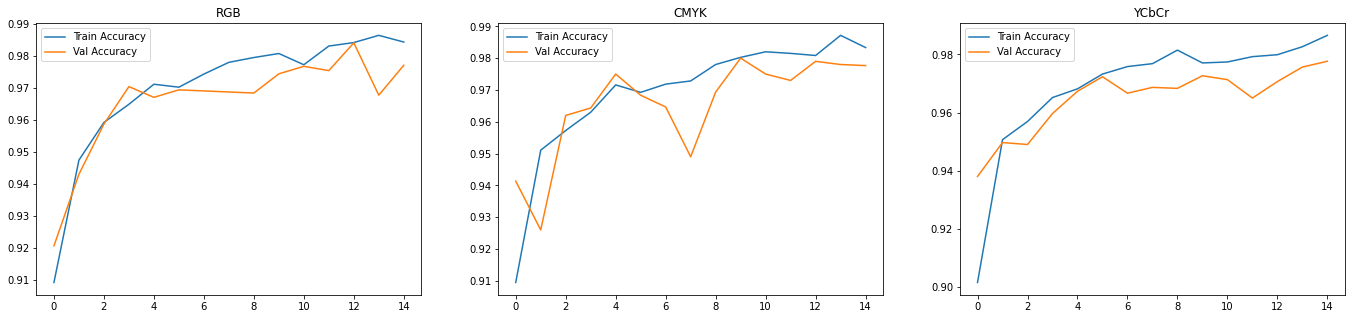

In [38]:
plt.figure(figsize=(40,5))
plt.subplot(1, 5, 1)
plt.title('RGB')
plt.plot(r1.history['loss'], label='Train Loss')
plt.plot(r1.history['val_loss'], label='Val Loss')
plt.legend()
plt.subplot(1, 5, 2)
plt.title('CMYK')
plt.plot(r2.history['loss'], label='Train Loss')
plt.plot(r2.history['val_loss'], label='Val Loss')
plt.legend()
plt.subplot(1, 5, 3)
plt.title('YCbCr')
plt.plot(r3.history['loss'], label='Train Loss')
plt.plot(r3.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()
plt.figure(figsize=(40,5))
plt.subplot(1, 5, 1)
plt.title('RGB')
plt.plot(r1.history['accuracy'], label='Train Accuracy')
plt.plot(r1.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.subplot(1, 5, 2)
plt.title('CMYK')
plt.plot(r2.history['accuracy'], label='Train Accuracy')
plt.plot(r2.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.subplot(1, 5, 3)
plt.title('YCbCr')
plt.plot(r3.history['accuracy'], label='Train Accuracy')
plt.plot(r3.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()

In [39]:
from tensorflow.keras.models import load_model
model1.save('nasnetlargergb.h5')
model2.save('nasnetlargecmyk.h5')
model3.save('nasnetlargeycbcr.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [40]:
y_pred1 = model1.predict(test_set1)
y_pred2 = model2.predict(test_set2)
y_pred3 = model3.predict(test_set3)

In [41]:
y_pred1

array([[1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]], dtype=float32)

In [42]:
y_pred2

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

In [43]:
y_pred3

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.0000000e+00, 0.0000000e+00, 2.7178318e-33],
       ...,
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 1.0000000e+00]], dtype=float32)

In [44]:
from sklearn.metrics import classification_report

Y_pred1 = model1.predict(test_set1)
y_pred1 = np.argmax(Y_pred1, axis=1)

print(classification_report(test_set1.classes, y_pred1))

              precision    recall  f1-score   support

           0       0.33      0.33      0.33      1000
           1       0.34      0.33      0.33      1000
           2       0.34      0.34      0.34      1000

    accuracy                           0.34      3000
   macro avg       0.34      0.34      0.34      3000
weighted avg       0.34      0.34      0.34      3000



In [45]:
from sklearn.metrics import classification_report

Y_pred2 = model2.predict(test_set2)
y_pred2 = np.argmax(Y_pred2, axis=1)

print(classification_report(test_set2.classes, y_pred2))

              precision    recall  f1-score   support

           0       0.33      0.35      0.34      1000
           1       0.32      0.32      0.32      1000
           2       0.33      0.31      0.32      1000

    accuracy                           0.33      3000
   macro avg       0.33      0.33      0.33      3000
weighted avg       0.33      0.33      0.33      3000



In [46]:
from sklearn.metrics import classification_report

Y_pred3 = model3.predict(test_set3)
y_pred3 = np.argmax(Y_pred3, axis=1)

print(classification_report(test_set3.classes, y_pred3))

              precision    recall  f1-score   support

           0       0.32      0.33      0.33      1000
           1       0.32      0.32      0.32      1000
           2       0.32      0.31      0.32      1000

    accuracy                           0.32      3000
   macro avg       0.32      0.32      0.32      3000
weighted avg       0.32      0.32      0.32      3000



In [48]:
import itertools
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [50]:
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, weight='bold', fontsize=16)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=14)
    plt.yticks(tick_marks, classes, fontsize=14)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center", fontsize=12, weight='bold',
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=16, weight='bold')
    plt.xlabel('Predicted label', fontsize=16, weight='bold')

Normalized confusion matrix
Normalized confusion matrix
Normalized confusion matrix


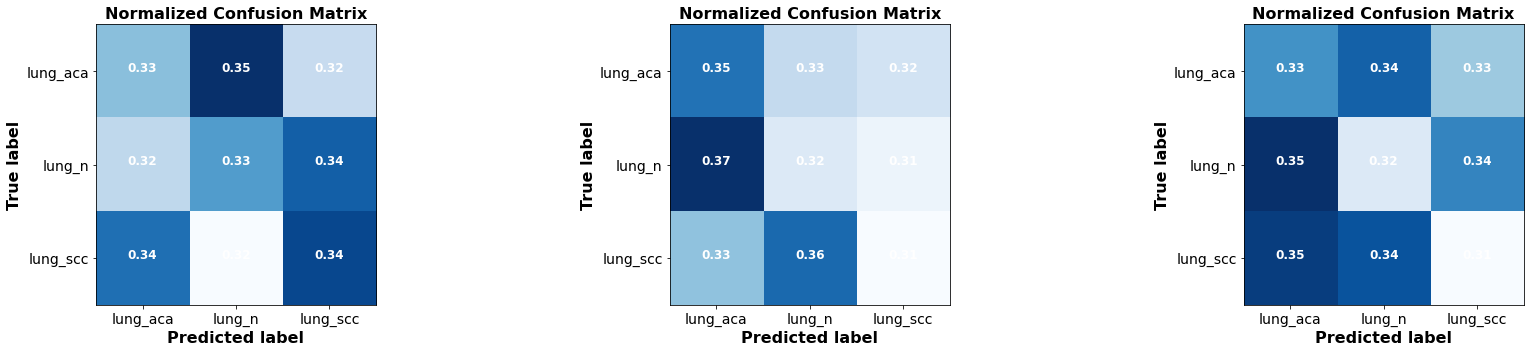

In [51]:
cnf_matrix1 = confusion_matrix(test_set1.classes, y_pred1)
cnf_matrix2 = confusion_matrix(test_set2.classes, y_pred2)
cnf_matrix3 = confusion_matrix(test_set3.classes, y_pred3)
np.set_printoptions(precision=2)
plt.figure(figsize=(40,5))
plt.subplot(1,5,1)
plt.title('RGB')
plot_confusion_matrix(cnf_matrix1, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,title='Normalized Confusion Matrix')
plt.subplot(1,5,2)
plt.title('CMYK')
plot_confusion_matrix(cnf_matrix2, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,title='Normalized Confusion Matrix')
plt.subplot(1,5,3)
plt.title('YCbCr')
plot_confusion_matrix(cnf_matrix3, classes=['lung_aca', 'lung_n', 'lung_scc'],normalize=True,title='Normalized Confusion Matrix')
plt.show()